In [1]:
import sys
import numpy as np
import pandas as pd

import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline


import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model


from keras.layers.pooling import MaxPooling2D

from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform


from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

2023-03-16 10:14:48.805842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 10:14:49.732432: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-16 10:14:49.732572: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
import os
from os import listdir

In [3]:
train = "/workspace/Shantan_Data/Bayesian2v/Steel_Surface/data1/train6/"
val = "/workspace/Shantan_Data/Bayesian2v/Steel_Surface/data1/val4/"
save = "/workspace/Shantan_Data/Bayesian2v/Steel_Surface/data1/save"

In [4]:

from PIL import Image

In [11]:
def loadimgs(path,n = 0):
    '''
    path = "/workspace/Shantan_Data/Bayesian2v/Steel_Surface/data1/train6/"
    
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = Image.open(image_path)
                image = image.resize((105,105))
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [12]:
X,y,c=loadimgs(train)

loading alphabet: defect2
need at least one array to stack
error - category_images: []
loading alphabet: defect4
need at least one array to stack
error - category_images: []
loading alphabet: defect6
need at least one array to stack
error - category_images: []
loading alphabet: defect5
need at least one array to stack
error - category_images: []
loading alphabet: defect3
need at least one array to stack
error - category_images: []
loading alphabet: defect1
need at least one array to stack
error - category_images: []


In [13]:
X.shape

(6, 50, 105, 105)

In [14]:
c

{'defect2': [0, 1],
 'defect4': [2, 3],
 'defect6': [4, 5],
 'defect5': [6, 7],
 'defect3': [8, 9],
 'defect1': [10, 11]}

In [15]:
with open(os.path.join(save,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

In [17]:
Xval,yval,cval=loadimgs(val)

loading alphabet: defect8
need at least one array to stack
error - category_images: []
loading alphabet: defect9
need at least one array to stack
error - category_images: []
loading alphabet: defect10
need at least one array to stack
error - category_images: []
loading alphabet: defect7
need at least one array to stack
error - category_images: []


In [18]:
with open(os.path.join(save,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [19]:
def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [20]:
def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [21]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [22]:
model = get_siamese_model((105, 105,1))
model.summary()

2023-03-16 10:21:50.820900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 10:21:52.481991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15716 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0
2023-03-16 10:21:52.483156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30971 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 4096)         38947648    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [23]:
optimizer = Adam(lr =1e-5)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

/opt/conda/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
X.shape

(6, 50, 105, 105)

In [25]:
with open(os.path.join(save, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training Categories: \n")
print(list(train_classes.keys()))

Training Categories: 

['defect2', 'defect4', 'defect6', 'defect5', 'defect3', 'defect1']


In [26]:
with open(os.path.join(save, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation Categories:", end="\n\n")
print(list(val_classes.keys()))

Validation Categories:

['defect8', 'defect9', 'defect10', 'defect7']


In [27]:
Xval.shape

(4, 30, 105, 105)

In [28]:
train_classes

{'defect2': [0, 1],
 'defect4': [2, 3],
 'defect6': [4, 5],
 'defect5': [6, 7],
 'defect3': [8, 9],
 'defect1': [10, 11]}

In [29]:
val_classes

{'defect8': [0, 1], 'defect9': [2, 3], 'defect10': [4, 5], 'defect7': [6, 7]}

In [30]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    
    else:
        X = Xval
        categories = val_classes
    
    
    n_classes, n_examples, w, h = X.shape
    categories = rng.choice(n_classes,size=(batch_size,), replace=True)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(h, w, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(h, w,1)
    
    return pairs, targets

In [31]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [32]:
def make_oneshot_task(N, s="val", fname=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
        
    n_classes, n_examples, w, h = X.shape
    print(n_classes)
    indices = rng.randint(0, n_examples,size=(N,))
    if fname is not None: # if language is specified, select characters for that language
        low, high = categories[fname]
        if N > high - low:
            raise ValueError("This fname ({}) has less than {} class".format(fname, N))
        categories = rng.choice(range(low,high),size=(N,), replace=True)

    else: # if no fname specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,), replace=True)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples, replace=True, size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [33]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [34]:
#hyperparameters
evaluate_every = 500 # interval for evaluating on one-shot tasks
batch_size = 28
n_iter = 20000 # No. of training iterations
N_way = 4 # how many classes for testing one-shot tasks
n_val = 120 # how many one-shot tasks to validate on
best = -1

In [35]:
model_path = "/workspace/Shantan_Data/Bayesian2v/Steel_Surface/data1/model/"

In [36]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------


2023-03-16 10:22:19.584767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8303



 ------------- 

Time for 500 iterations: 0.333060097694397 mins
Train Loss: 3.384856700897217
Evaluating model on 120 random 4 way one-shot learning tasks ... 

4
1/1 [==============================] - 0s 231ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 32ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 29ms/step
4
1/1 [==============================] - 0s 29ms/step
4
1/1 [==============================] - 0s 31ms/step
4
1/1 [==============================] - 0s 82ms/step
4
1/1 [==============================] - 0s 98ms/step
4
1/1 [===================

In [37]:
ways = np.arange(1,5)
resume =  False
trials = 100

In [38]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
#     nn_acc = test_nn_accuracy(N, trials)
#     nn_accs.append(nn_acc)
#     print ("NN Accuracy = ", nn_acc)
    print("------------------------------------------------------------------------------------------------")

Evaluating model on 100 random 1 way one-shot learning tasks ... 

4
1/1 [==============================] - 0s 73ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 27ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 27ms/step
4
1/1 [==============================] - 0s 27ms/step
4
1/1 [==============================] - 0s 29ms/step
4
1/1 [==============================] - 0s 29ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 27ms/step
4
1/1 [==============================] - 0s 27ms/step
4
1/1 [==============================] - 0s 27ms/step
4
1/1 [========

In [39]:
from keras.layers import Concatenate

In [40]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [41]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

6


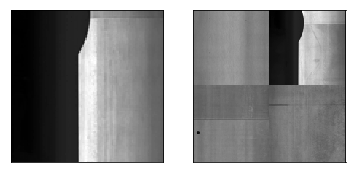

In [57]:
inputs, targets = make_oneshot_task(4,"train")
plot_oneshot_task(inputs)

4


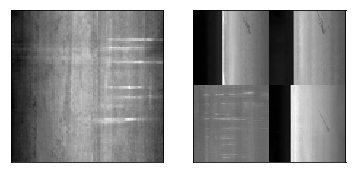

In [58]:
inputs, targets = make_oneshot_task(4,"test")
plot_oneshot_task(inputs)